# Regression case study with Bayesian Neural Networks

**Goal:** In this notebook you will investigate which advantages Bayesian NNs can offer in a regression task for a Normal Distributed CPD. First, you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via MC-dropout. You will compare the results of the different models, especially you will have a look at the extrapolation case.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
A simulated dataset with a sine wave that has a small positive linear trend and a variance that depends on the amplitude.

**Content:**
* Simulate the data set
* Fit a non-Bayesian regression model yielding a single $\mu_x$ and $\sigma_x$ for a fixed value of $x$
* Fit a Bayesian regression model via variational inference yielding a distribution for $\mu_x$ and $\sigma_x$ 
* Fit a Bayesian regression model via dropout yielding a distribution for $\mu_x$ and $\sigma_x$
* Comparing the CPD of all three approaches


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb)

In [0]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [0]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


In [0]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

#### Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


## Data generation

Here, we use the same data generation function, that we already used in chapter 4 and in the notebook https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb 

376

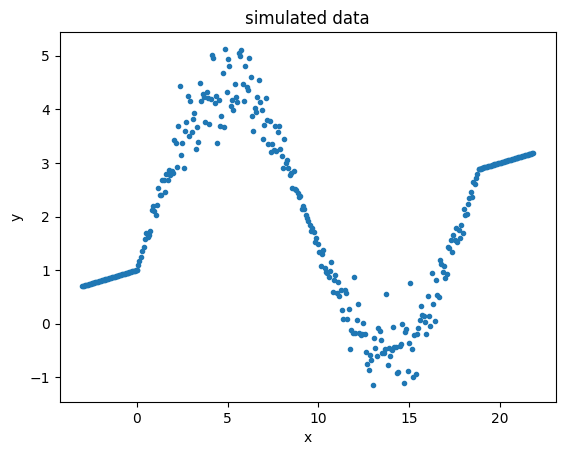

In [0]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

## use custom function to simulate some data 
x,y = create_sine_data(256) # Note that the model has been trained with 2048 data points
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)
n

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$ of a Gaussian. We use the same model, which we used in chapter https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb but this time, we define the output with tensorflow probability.

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_nobay = Model(inputs=inputs, outputs=dist)
model_nobay.compile(Adam(), loss=NLL) 

In [0]:
model_nobay.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_15 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_16 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 42        
_________________________________________________________________
distribution_lambda_5 (Distr ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
________________________________________________________

In [0]:
# history = model_nobay.fit(x, y, epochs=5000, verbose=0,batch_size=32)
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_nobay.hdf5")
model_nobay.load_weights("model_nobay.hdf5")

In [0]:
model_nobay_mean = Model(inputs=inputs, outputs=dist.mean())
model_nobay_sd = Model(inputs=inputs, outputs=dist.stddev())

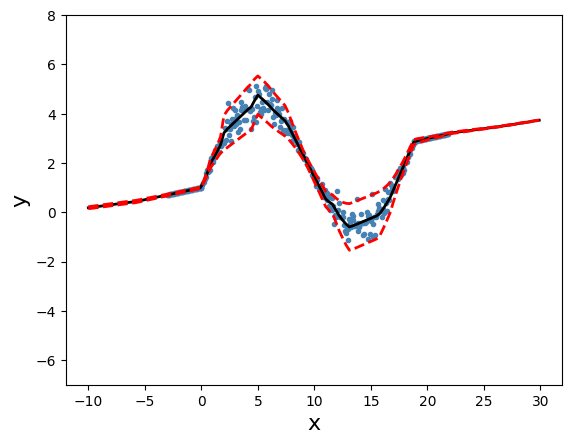

In [0]:
x_pred = np.arange(-10,30,0.3) 

def make_no_bayes_plot(ax, model_mu, model_sig, add_std=False, stretch=1, alpha_data=1.0,ylim=[-1,2]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    mus_pred = model_mu.predict(x_pred)
    sig_pred = model_sig.predict(x_pred)
    ax.plot(x_pred,mus_pred * stretch,color="black",linewidth=2)
    if add_std:
        ax.plot(x_pred,mus_pred + 2 * sig_pred,color="red",linestyle="--",linewidth=2) 
        ax.plot(x_pred,mus_pred - 2 * sig_pred,color="red",linestyle="--",linewidth=2)
    ax.set_ylim(ylim)

make_no_bayes_plot(plt.gca(),model_nobay_mean, model_nobay_sd, add_std=True,ylim=[-7,8])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

The non-bayesian model indicates a standard deviation of zeros in the regions where you leave the known ground. It fails to model the epistemic uncertainty.

## Bayesian Model using VI

Now we will train a bayesian neural network via variational inference. We again use the same architecture as above. But now instead of weights, we approximate the posterior of the weights with a normal distribution. 

The normal distribution has two paramters and therefore, we have almost doubled our paramters (we don't use a distribution for bias terms) in the network.  Because the training takes a lot of time, you will load an already trained network with the learning curve.


We will create 3 models accessing the network

1. the model `model_vi_mean` accessing the head of the network for the parameter $\mu_x$ of the CPD
2. the model `model_vi_sd` accessing the head of the network for the parameter $\sigma_x$ of the CPD
3. the model `model_vi` it self is the CPD of $y$ given by $p(y|x) = N(y,\mu_x,\sigma_x)$

In [0]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL) 

model_vi_mean = Model(inputs=inputs, outputs=dist.mean())
model_vi_sd = Model(inputs=inputs, outputs=dist.stddev())

In [0]:
model_vi.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_12 (DenseFlipo (None, 20)                80        
_________________________________________________________________
dense_flipout_13 (DenseFlipo (None, 50)                2100      
_________________________________________________________________
dense_flipout_14 (DenseFlipo (None, 20)                2040      
_________________________________________________________________
dense_flipout_15 (DenseFlipo (None, 2)                 84        
_________________________________________________________________
distribution_lambda_6 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
________________________________________________________

In [0]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_vi.fit(x, y, epochs=20000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_vi.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# model_vi.save_weights('model_vi.hdf5')
# plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi.hdf5", "model_vi.hdf5")
model_vi.load_weights("model_vi.hdf5")

In the next cell you can see that you get a different prediction for the same point, when you predict it multilple times. Everytime you sample the prediction for the mean $\mu$ and standarddev $\sigma$ changes a bit. 

In [0]:
x_pred_tmp = np.array([0]) 
print('Mean:')  
for r in range(5):
    print(np.round(model_vi_mean.predict(x_pred_tmp), 3))
print('Stddev:')   
for r in range(5):
    print(np.round(model_vi_sd.predict(x_pred_tmp), 3))


Mean:
[[1.046]]
[[0.999]]
[[1.008]]
[[1.025]]
[[1.024]]
Stddev:
[[0.052]]
[[0.064]]
[[0.044]]
[[0.052]]
[[0.044]]


We now do this for several runs for the prediction dataset, and store the values for the prediced standard deviation and the predicted mean.

In [0]:
# Predicting the mu and sigma
runs = 200
vi_mus =np.zeros((runs,len(x_pred)))
vi_stds=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_mus[i,:]=np.reshape(model_vi_mean.predict(x_pred),len(x_pred))
    vi_stds[i,:]=np.reshape(model_vi_sd.predict(x_pred),len(x_pred))

### Parameter $\mu_x$ for several runs 

We plot the parameters $\mu_x$ for the different runs. 

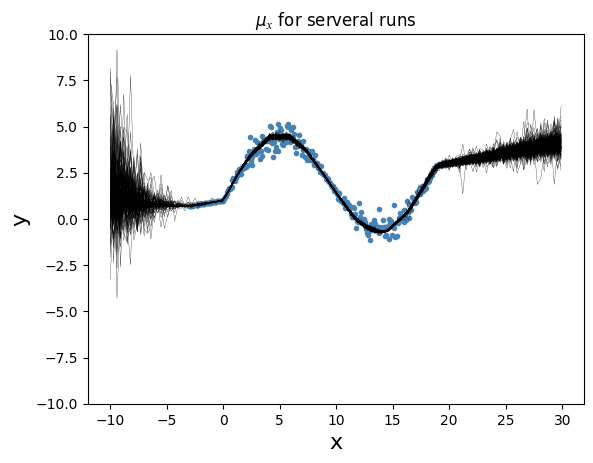

In [0]:
def make_bayes_plot_runs(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    for i in range(0,runs):
      ax.plot(x_pred, preds[i,0:400],color="black",linewidth=0.2)
    ax.set_ylim(ylim)
  
ax = plt.subplot()
make_bayes_plot_runs(ax, vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('$\mu_𝑥$ for serveral runs')
plt.show()

In the regions where you leave the known ground, you see quite some fluctuations. Instead of these fluctutions we plot the average and two times the standdard deviation, below.

#### Taking statistics of the different runs 

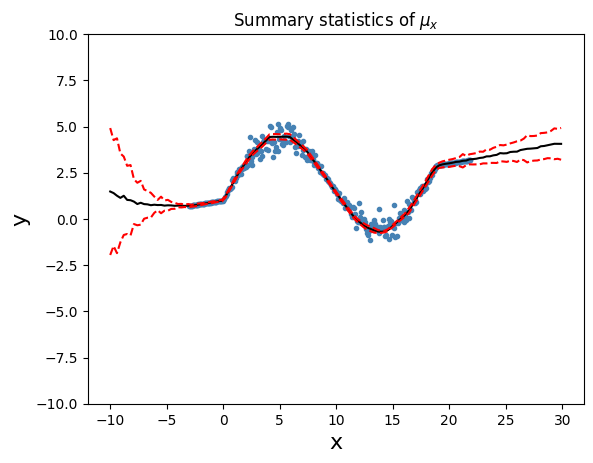

In [0]:
def make_bayes_plot_runs_avg(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd      
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5)
    ax.plot(x_pred,np.mean(preds,axis=0)+2*np.std(preds,axis=0),color="red",linewidth=1.5,linestyle="--")
    ax.plot(x_pred,np.mean(preds,axis=0)-2*np.std(preds,axis=0),color="red",linewidth=1.5,linestyle="--")

ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Summary statistics of $\mu_x$')
plt.show()

### The paramter $\sigma_x$ for several runs

Similar, we look on the estimation of $\sigma$ and it's spread. 

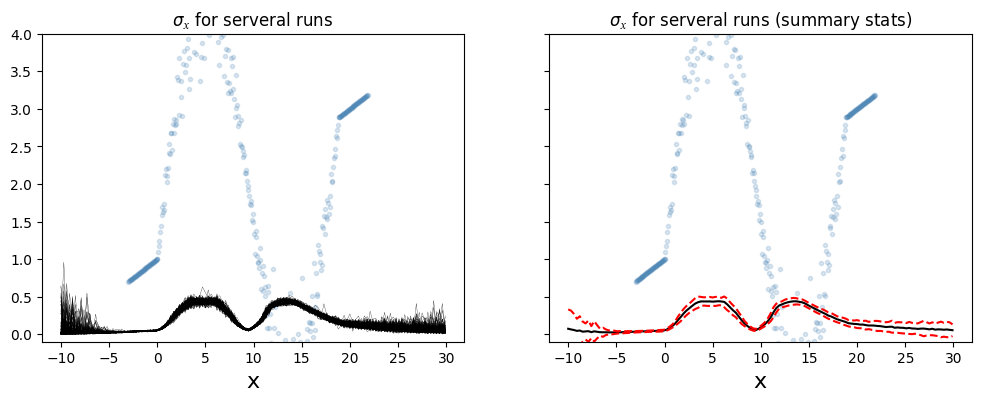

In [0]:
f,ax = plt.subplots(1,2,sharex=True, sharey=True,figsize=(12,4))
make_bayes_plot_runs(ax[0], preds=vi_stds, alpha_data=0.2, ylim=[-0.1,4])
ax[0].set_title('$\sigma_𝑥$ for serveral runs')
ax[0].set_xlabel("x",size=16)

make_bayes_plot_runs_avg(ax[1],vi_stds, alpha_data=0.2, ylim=[-0.1,4])
ax[1].set_title('$\sigma_𝑥$ for serveral runs (summary stats)')
ax[1].set_xlabel("x",size=16)


plt.show()

Inside the data region, from -3 to 25, $\sigma_x$ goes up, where the data has a larger spread (aleatoric uncertainty). Inside the data region the differences of the individual runs are small; there is no epistemic uncertainty. Leaving the range the data range, the runs differ (especially for values < -3); there is epistemic uncertainty. This behavior is less pronounced for the region larger then 25.

### The CPD for several runs

Let's draw samples form the CPD. The CPD contains contributions of the uncertainty of $\mu_x$ and $\sigma_x$.

In [0]:
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

And plot their averages and standard deviation.

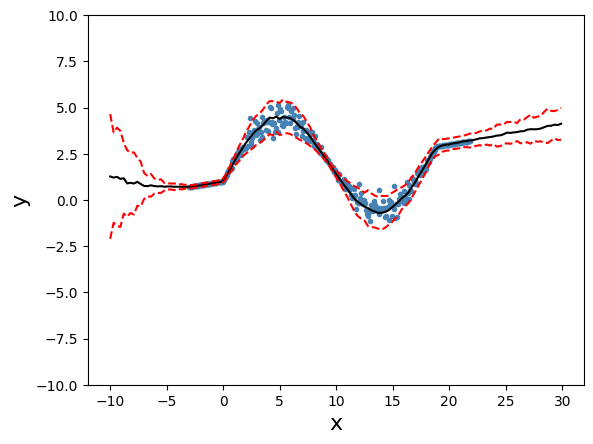

In [0]:
ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## MC Dropout

We repeat the analysis from above but this time using MC-Dropout instead of VI. And compare the results with the VI Bayesian network and the non-Bayesian network.

In [0]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [0]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.0002), loss=NLL) 

In [0]:
model_mc.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 500)               100500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0  

In [0]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_mc.fit(x, y, epochs=1000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_mc.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc.hdf5", "model_mc.hdf5")
model_mc.load_weights("model_mc.hdf5")

In [0]:
model_mc_mean = Model(inputs=inputs, outputs=dist_mc.mean())
model_mc_sd = Model(inputs=inputs, outputs=dist_mc.stddev())

In [0]:
# Predicting the mu and sigma
mc_mus=np.zeros((runs,len(x_pred)))
mc_std=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
  mc_mus[i,:]=np.reshape(model_mc_mean.predict(x_pred),len(x_pred))
  mc_std[i,:]=np.reshape(model_mc_sd.predict(x_pred),len(x_pred))

In [0]:
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

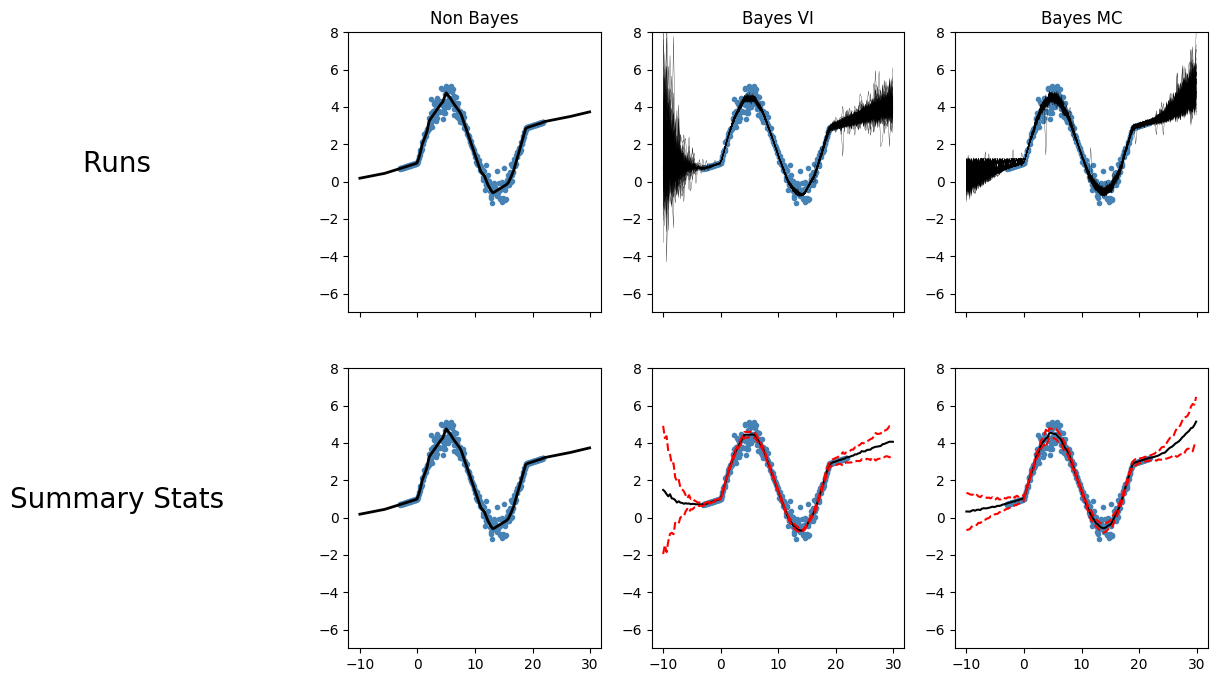

In [0]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,4,sharex=True, sharey=False,figsize=(15,8))



make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,1].set_title('Non Bayes')
make_no_bayes_plot(ax[1,1],model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])


ax[0,2].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,2], vi_mus, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,2], vi_mus, ylim=[-7,8])

ax[0,3].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,3], mc_mus, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,3], mc_mus, ylim=[-7,8])

ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "Runs",fontsize=20,horizontalalignment='center')

ax[1,0].axis('off')
ax[1,0].text(0.5,0.5, "Summary Stats",fontsize=20,horizontalalignment='center')


plt.savefig('ch08_good_mu.pdf')

plt.show()

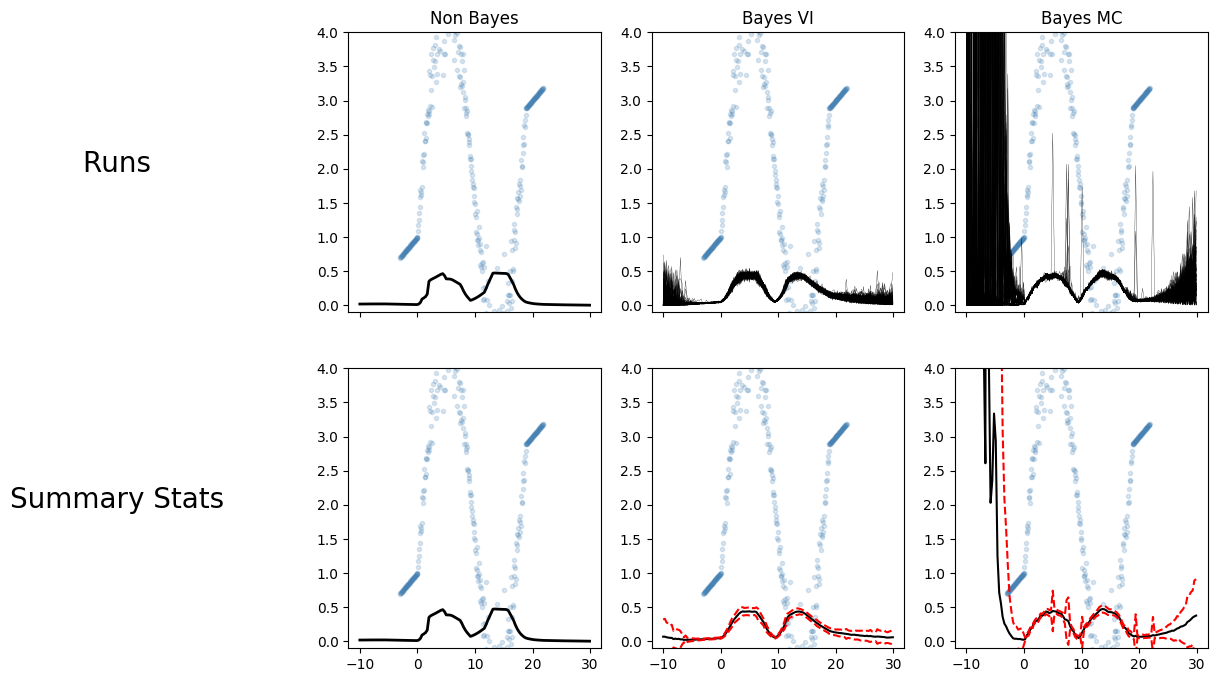

In [0]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,4,sharex=True, sharey=False,figsize=(15,8))



make_no_bayes_plot(ax[0,1],model_nobay_sd, model_nobay_sd,alpha_data=0.2 ,add_std=False,ylim=[-0.1,4], stretch=1)
ax[0,1].set_title('Non Bayes')
make_no_bayes_plot(ax[1,1],model_nobay_sd, model_nobay_sd,alpha_data=0.2, add_std=False, ylim=[-0.1,4], stretch=1)


ax[0,2].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,2], vi_stds,  alpha_data=0.2,ylim=[-0.1,4])
make_bayes_plot_runs_avg(ax[1,2], vi_stds,  alpha_data=0.2,ylim=[-0.1,4])

ax[0,3].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,3], mc_std,  alpha_data=0.2,ylim=[-0.1,4])
make_bayes_plot_runs_avg(ax[1,3], mc_std,  alpha_data=0.2,ylim=[-0.1,4])

ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "Runs",fontsize=20,horizontalalignment='center')

ax[1,0].axis('off')
ax[1,0].text(0.5,0.5, "Summary Stats",fontsize=20,horizontalalignment='center')


plt.savefig('ch08_good_sig.pdf')

plt.show()

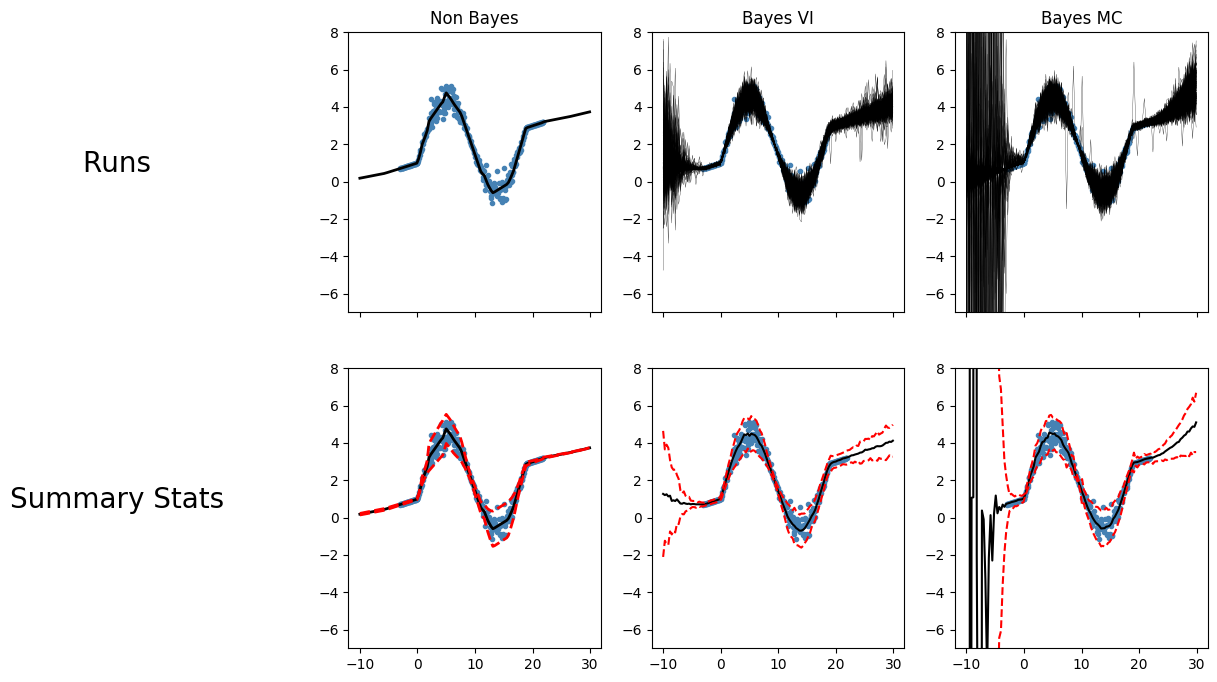

In [0]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,4,sharex=True, sharey=False,figsize=(15,8))



make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,1].set_title('Non Bayes')
make_no_bayes_plot(ax[1,1],model_nobay_mean, model_nobay_sd, add_std=True,ylim=[-7,8])


ax[0,2].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,2], vi_cpd, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,2], vi_cpd, ylim=[-7,8])

ax[0,3].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,3], mc_cpd, ylim=[-7,8])
make_bayes_plot_runs_avg(ax[1,3], mc_cpd, ylim=[-7,8])

ax[0,0].axis('off')
ax[0,0].text(0.5,0.5, "Runs",fontsize=20,horizontalalignment='center')

ax[1,0].axis('off')
ax[1,0].text(0.5,0.5, "Summary Stats",fontsize=20,horizontalalignment='center')


plt.savefig('ch08_good_mu.pdf')

plt.show()

In the region where we have training data all approaches yield similar results: They uncertainty captured by the spread of the CPD is large in regions where the data spread is large. All models thus are able to model the aleatoric uncertainty. When we leave the region, where we have data and go into the extrapolation region, the non-Bayesian approach fails. It assumes 95% of the data in an unrealistically narrow region. The Bayesian approaches knows when they don’t know and can express  their uncertainties when leaving known grounds.
